# Hand motions classification using non-invasive EEG recordings
### by Cedric Simar and Antoine Passemiers
<hr/>

## Table of content

* [0 - Introduction](#introduction)
  * [0.1. Problem description](#problem-description)


* [1 - Preprocessing](#preprocessing)
  * [1.1. Import useful libraries](#import-libraries)
  * [1.2. Load the data](#load-data)
  * [1.3. Low-pass filtering](#low-pass-filtering)
  * [1.4. Downsampling](#downsampling)


* [2 - A first naive approach: learn from raw EEG samples](#learn-from-raw-data)
  * [2.1. Random Forests (first model)](#random-forests)
    * [2.1.1 VC-dimension of random forests](#random-forests-vc)
    * [2.1.2 Random forest pruning](#random-forest-pruning)
  * [2.2  Logistic regression (second model)](#logistic-regression)
    * [2.2.1 VC dimension of logistic regression](#logistic-regression-vc)


* [3. Riemannian-based kernel trick](#kernel-trick)
  * [3.1. Riemannian-based SVM (fourth model)](#ghmm)
  * [3.2. Linear Discriminant Analysis (fifth model)](#lda)


* [4 - Dealing with non-stationary data](#non-stationary-data)
  * [4.1. Gaussian Hidden Markov Models (third model)](#ghmm)


* [5. ANN, LSTM and weird stuff](#CAFE)


* [X. Bibliography](#bibliography)

## Introduction <a class="anchor" id="introduction"></a>
<hr/>

Note: This notebook has been designed in order to serve several purposes:
1. Introduce different models either that have been successfully applied to EEG-based problems in the past or that are considered by us as being relevant given the nature of the task.
2. Constantly refer to generalization theory while selecting our best models using Structural Risk Minimization (SRM)
3. Present code excerpts used to achieve good performance on the [Kaggle competition](#bib-kaggle) about Grasp-and-Lift EEG detection.

### Problem description <a class="anchor" id="problem-description"></a>

A Brain-Computer Interface (BCI) is a system that establishes a direct communication between a brain and a device without using the neuromuscular pathways. The design and implementation of a BCI system typically require a multidisciplinary approach in order to combine expertise from different fields such as neurophysiology, electronics, signal processing and algorithmics.

Currently, the main field of application of BCI systems is the medical domain. Each year, thousands of patients suffer from severe motor paralysis caused by a trauma or a generative disease. The research objective of the [Kaggle competition](#bib-kaggle) is to develop accurate and robust algorithms that can be integrated in BCI systems to considerably enhance the quality of life of these patients by allowing them to regain some control over their environment. More specifaclly the competition focus on classifying hand motions of 6 different movements: 'HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', and 'BothReleased'. With the help of Machine Learning classification algorithms integrated in a BCI system, the hope is to be able to map brain waves to the desired movement and, eventually control a robotic arm or a prosthesis capable of playing the role of a hand.

### EEG analysis <a class="anchor" id="eeg-analysis"></a>

An electroencephalogram (EEG) uses multiple electrodes (channels) to measure the electrical activity of post-synaptic potentials of cortical neurons located at specific parts of the brain. These electrodes are placed at precise locations on the patient' scalp following the International 10-20 system as illustrated hereunder. 

<figure style="text-align:center;">
  <img src="imgs/EEG_Electrode_Numbering.jpg" style="width:450px;">
  <figcaption> Source: [Kaggle](#bib-kaggle) </figcaption>
</figure>

The purpose of an EEG signal analysis is to use advanced signal processing techniques to extract relevant information about the brain state that are not directly visible in the time domain in order to infer the state of the patient or to diagnose brain-related pathologies. 

### Data <a class="anchor" id="intro-data"></a>

The study and data to support our work was first published in [Nature](#data-nature) and later made publicly available for the purpose of a [Kaggle competition](#bib-kaggle). <br> <br>
The data, totalling 3,936 grasp and lift trials, was collected from twelve participants. "The participant’s task in each trial was to reach for a small object, grasp it using their index finger and thumb, and lift it a few centimetres up in the air, hold it stably for a couple of seconds, and then replace and release the object. The beginning of the reach and the lowering of the object was cued by an LED, otherwise the pace of the task was up to the participant. During all trials, we recorded 32 channels of EEG, 5 channels of EMG from the shoulder, forearm, and hand muscles, the position of the arm, thumb and index finger and the object, and the forces applied to the object by the precision grip. We defined 16 behaviourally relevant events and extracted them for every trial. These event times are available along with the scripts used to generate them and the raw data." [Nature](#data-nature) 

In [1]:
from IPython.display import HTML
url = "https://www.youtube.com/embed/y3_Izuop2gY?rel=0&amp;controls=0&amp;showinfo=0"
HTML('<iframe style="display:block" width="560" height="315" src="%s" frameborder="0" allowfullscreen></iframe>' % url)

When using predictive models with EEG data, it is considered good practice to build patient-specific models rather than one global model for all patients. At first, it would be tempting to aggregate datasets from different patients in order to develop a single model trained with more samples that would therefore be able to better generalize compared to patient-specific models trained with fewer samples. However, this assumption is erroneous and is not considered good practice due to the large divergence between humain brains and patient-specific conditions or mental states that affect the amplitude and rythms of brain waves. For this reason, we chose to use the EEG recordings from the 8 sessions of one patient as the sole source of data for all our models.

### Data exploration <a class="anchor" id="data-exploration"></a>

In order to determine what kind of preprocessing should be applied in order to transform the raw EEG signals into meaningful features that will constitute the input of our classifiers, let's try to visualize and explore our dataset further. <br> <br>
Note: the data from each session of subject 1 (as originally posted on the [Kaggle competition](#bib-kaggle) website) was aggregated in one single compressed file for the use of this notebook. <br> <br>
First, we load the compressed dataset.

In [1]:
import pickle
import gzip

print("Loading compressed dataset... ", end='')
with gzip.GzipFile("./data/sub1_raw.data", 'rb') as handle:
        dataset = pickle.load(handle)
print("done.")

Loading compressed dataset... done.


Now we will explore the data using  [MNE](#mne-website), an open-source Python library for visualizing and analyzing neurophysiological data such as EEG recordings.

#### Visualization in the time domain

In [161]:
import mne 
import numpy as np

# Electrode names
electrode_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

# Label names
event_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoad', 'LiftOff', 'Replace', 'BothReleased']

# Sampling frequency
sampling_frequency = 500

# Definition of electrode types
electrode_types = ['eeg'] * len(electrode_names) + ['stim'] * len(event_names)

# Creation of the MNE info object
electrode_montage = mne.channels.read_montage("standard_1005", electrode_names);
electrodes_and_events = electrode_names[:]
electrodes_and_events.extend(event_names)

mne_info = mne.create_info(ch_names = electrodes_and_events, sfreq = sampling_frequency, 
                           ch_types = electrode_types, montage = electrode_montage);

# Concatenate data and labels
raw_data_labels = np.concatenate((dataset[0][0].T, dataset[1][0].T))

# Creation of the MNE raw data object
raw = mne.io.RawArray(raw_data_labels, mne_info, verbose = False);

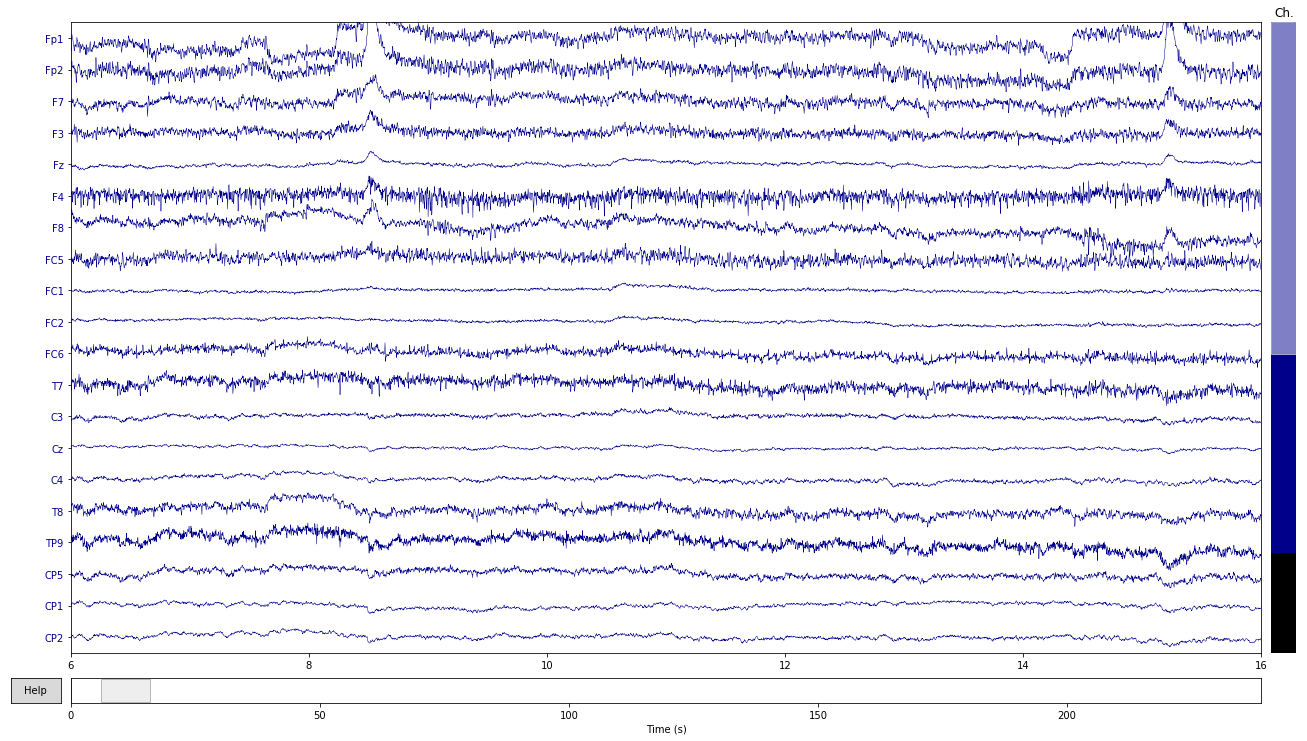

In [135]:
# Plot the EEG signals
raw.plot(start = 6, group_by = 'type', block=True, scalings=dict(eeg=1e3/2), color=dict(eeg="darkblue"));

As we anticipated, the time domain doesn't seem to hold much visible valuable information. <br>
Nevertheless, we can observe that the raw signals have already been cleaned from physiological and non-physiological EEG artifacts such as power line noise, eye blinks or muscle movements.

#### Visualization in the frequency domain

During a motor task, alpha (8-12 Hz) and beta (15-25 Hz) EEG frequency bands are [suppressed](#alpha-beta) over the contralateral sensorimotor cortex (e.g. electrodes C3 and C4), which should result in an observable decrease in power called event-related desynchronization (ERD).

In [136]:
"""
This code is a slightly modified version of a Kaggle kernel for the visualization of EEG data
The original code can be found here: https://www.kaggle.com/alexandrebarachant/common-spatial-pattern-with-mne/code
"""

from scipy.signal import welch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy

# Filter the data around the frequencies of interest
raw_prime = deepcopy(raw) 
picks = mne.pick_types(raw_prime.info, eeg = True);
raw_prime.filter(7, 35, picks = picks, method = "iir");

# Select an event and find the data samples that correspond to this event
selected_events = mne.find_events(raw_prime, stim_channel = "FirstDigitTouch", verbose = False);

# Select the epochs 1 second before and after the movement
epochs_before = mne.Epochs(raw_prime, selected_events, {"before": 1}, -2, -0.5, picks = picks, proj = False, 
                          baseline = None, preload = True, verbose = False);
y = [1] * len(epochs_before)

epochs_after = mne.Epochs(raw_prime, selected_events, {"after": 1}, 0.5, 2, picks = picks, proj = False, 
                          baseline = None, preload = True, verbose = False);
y += [-1] * len(epochs_after)
y = np.array(y)

epochs_after.times = epochs_before.times
all_epochs = mne.concatenate_epochs((epochs_before, epochs_after));

# Compute Common Spatial Pattern filters
csp = mne.decoding.CSP(reg="oas");
csp.fit(all_epochs.get_data(), y);

# Compute Power Spectral Density on each epoch
psd = []
for epoch in all_epochs.get_data():
    f, p = welch(np.dot(csp.filters_[0,:].T, epoch), sampling_frequency, nperseg = 512)
    psd.append(p)

psd = np.array(psd)

68 matching events found
No baseline correction applied
Estimating covariance using OAS
Done.
Estimating covariance using OAS
Done.


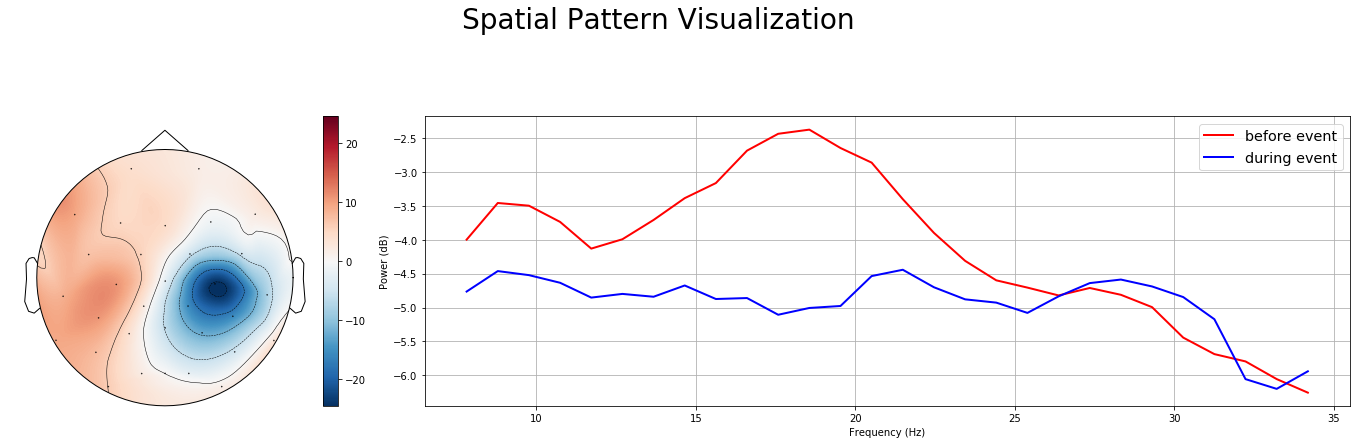

In [137]:
# Prepare topoplot
_, epos, _, _, _ = mne.viz.topomap._prepare_topo_plot(all_epochs, "eeg", None)

# Plot first pattern
pattern = csp.patterns_[0,:]
pattern -= pattern.mean()

fig, ax_topo = plt.subplots(1, 1, figsize = (24, 8))
title = 'Spatial Pattern Visualization'
fig.suptitle(title, fontsize=28)
img, _ = mne.viz.topomap.plot_topomap(-pattern, epos, axes = ax_topo, show = False)
divider = make_axes_locatable(ax_topo)

# Add axes for colorbar
ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(img, cax=ax_colorbar)

# Plot spectrum
fix = (f > 7) & (f < 35)
ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
ax_spectrum.plot(f[fix],np.log(psd[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
ax_spectrum.plot(f[fix],np.log(psd[y==-1][:,fix].mean(axis=0).T),'-b',lw=2)
ax_spectrum.set_xlabel('Frequency (Hz)')
ax_spectrum.set_ylabel('Power (dB)')
plt.grid();
plt.legend(['before event','during event'], fontsize='x-large')
plt.show();

As expected, using spacial pattern visualization techniques such as Common Spatial Pattern (CSP), we can observe a noticable desynchronization during a movement (after the begining of the event) in the alpha (8-12 Hz) and beta (15-25 Hz) frequency bands. Additionally, when we plot a topographic map of the EEG signals (looking down down at the top of the head) we can observe that the desynchronization is clearly located over the sensorimotor cortex (here over the C4 electrode). Next, we focus on the identified sensorimotor region by plotting localized Event-Related Desynchronization / Synchronization maps.

In [138]:
"""
This code is a slightly modified version of an example provided on the MNE website
Authors: Clemens Brunner
License: BSD (3-clause)
The original code is at: https://mne-tools.github.io/dev/auto_examples/time_frequency/plot_time_frequency_erds.html
"""

from matplotlib.colors import LinearSegmentedColormap
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

# Create data epochs around events of interest for the electrodes C3, CZ and C4
raw_prime = deepcopy(raw);
selected_events = mne.find_events(raw_prime, stim_channel = "FirstDigitTouch", verbose = False);
picks = mne.pick_channels(raw_prime.info["ch_names"], ["C3", "Cz", "C4"]);
epochs = mne.Epochs(raw_prime, selected_events, {"event" :1}, -2.5, 4.5, picks=picks, baseline=None, preload=True);

# Compute ERDS maps
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs             # use constant t/f resolution
vmin, vmax = -1, 1.5         # set min and max ERDS values in plot
baseline = [-2, 0]           # baseline interval (in s)

cmap = plt.cm.RdBu
vzero = abs(vmin) / (vmax - vmin)
index_old = np.linspace(0, 1, cmap.N)
index_new = np.hstack([np.linspace(0, vzero, cmap.N // 2, endpoint=False),
                       np.linspace(vzero, 1, cmap.N // 2)])
cdict = {"red": [], "green": [], "blue": [], "alpha": []}
for old, new in zip(index_old, index_new):
    r, g, b, a = cmap(old)
    cdict["red"].append((new, b, b))
    cdict["green"].append((new, g, g))
    cdict["blue"].append((new, r, r))
    cdict["alpha"].append((new, a, a))
cmap = LinearSegmentedColormap("erds", cdict)
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None)  # for cluster test

tfr = tfr_multitaper(epochs["event"], freqs=freqs, n_cycles=n_cycles,
                         use_fft=True, return_itc=False, average=False,
                         decim=2)
tfr.crop(-2, 4)
tfr.apply_baseline(baseline, mode="percent")

34 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 34 events and 3501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: percent)


<EpochsTFR  |  time : [-2.000000, 4.000000], freq : [2.000000, 35.000000], epochs : 34, channels : 3, ~39.7 MB>

Start Clustering
This may take a few seconds..
No baseline correction applied
No baseline correction applied
No baseline correction applied
Done.


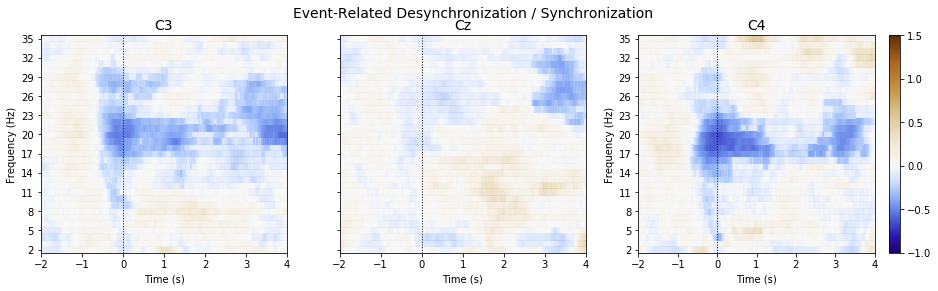

In [139]:
# Plot the ERDS maps

print("Start Clustering")
print("This may take a few seconds..")

fig, axes = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={"width_ratios": [10, 10, 12]})

for ch, ax in enumerate(axes):  # for each channel
    # positive clusters
    _, c1, p1, _ = pcluster_test(tfr.data[:, ch, ...], tail=1, **kwargs, verbose = False);
    # negative clusters
    _, c2, p2, _ = pcluster_test(tfr.data[:, ch, ...], tail=-1, **kwargs, verbose = False);

    # note that we keep clusters with p <= 0.05 from the combined clusters
    # of two independent tests; in this example, we do not correct for
    # these two comparisons
    c = np.stack(c1 + c2, axis=2)  # combined clusters
    p = np.concatenate((p1, p2))  # combined p-values
    mask = c[..., p <= 0.05].any(axis=-1)

    # plot TFR (ERDS map with masking)
    colorb = True if ch == 2 else False
    tfr.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                       axes=ax, colorbar=colorb, show=False, mask=mask);
    
    ax.set_title(epochs.ch_names[ch], fontsize=14)
    ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
    if not ax.is_first_col():
        ax.set_ylabel("")
        ax.set_yticklabels("")

print("Done.")

title = 'Event-Related Desynchronization / Synchronization'
fig.suptitle(title, fontsize=14)
plt.show()

Event-Related Desynchronization / Synchronization (ERDS) maps (also called Event-Related Spectral Perturbation, ERSP)  plot the decrease or increase in power in specific frequency bands relative to a baseline. Here, we used the signals of the selected electrodes before the event as a baseline to produce a graphic representation in the frequency domain of how the signals over the same electrodes differ from the baseline after the event. <br> <br>
We can observe a noticable desynchronization (compared to the baseline) in the next few seconds after the event in the beta (15-25 Hz) frequency band in both C3 and C4 electrodes (sensorimotor cortex), which confirms our previous observations.

### Data exploration summary <a class="anchor" id="preprocessing"></a>
The exploration of EEG data allows us to formulate the following conjectures:
1. Few useful information may be retrieved from the time domain
2. Spatial information through electrodes locations are important factors to target specific regions of interest
3. Frequency domain may contain enough information to accurately detect and classify hand-motion events

### Approaches <a class="anchor" id="import-libraries"></a>
On the basis of the conjectures formulated hereabove, we decided to explore the following approaches:
1. Riemannian Geometry with Support Vector Machines
2. Power Spectral Density with Logistic Regression
3. Raw signal with Deep Learning voodoo magic

## General methodology

Validation set blablabla

## Deep Learning approach

### Approach description

TODO

The input to the neural network consists of a 32 channels x SAMPLE_LENGTH EEG signal recording

Layer 1: 1D spatial convolution over the channels to condense NUM_CHANNELS to the number of the convolutional filters (thus reducing the input dimension). 
         Linear transformation, no activation function used

Layer 2: 1D temporal convolution over the raw signal of each channel. 
         Activation function: ReLu
         Max pooling 
         

Layer 3: Second 1D temporal convolution
         Activation function: ReLu
         Max pooling
         Flatten the output of the max pooling layer to get the input of the FC layer
         Dropout layer with p = 0.5

Layers 4 and 5: Standard Fully Connected layers separated by Dropout layers

Layer 6: Output layer 
        using sigmoid cross entropy (not mutually exclusive) with logits so no need of an activation function at the end of the CNN



### Model analysis

VC 

### Classification

#### Global variables

In [153]:
SERIES_TRAINING_INDICES = [0, 1, 3, 4, 6, 7]
SERIES_VALIDATION_INDICES = [2, 5]
SAMPLE_LENGTH = 3584                   # ~7 seconds of signal
NUM_CHANNELS = 32                      # Number of electrodes recording the EEG signals
NUM_EVENTS = 6
MINIBATCH_SIZE = 64
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001
MOMENTUM = 0.9

#### Customized batch generator

In [154]:
class BatchGenerator:

    """
    Generate random batches to feed the Convolutional Neural Network
    The batches can be generated: 
            - for Gradient Descent: from the training set
            - for model evaluation: from the validation set (the whole validation set couldn't be stored in RAM)
    """

    def __init__(self, dataset):

        # load subjects data file(s)
        self.data, self.labels = dataset
        
        self.training_data = self.data[SERIES_TRAINING_INDICES]
        self.training_labels = self.labels[SERIES_TRAINING_INDICES]

        self.validation_data = self.data[SERIES_VALIDATION_INDICES]
        self.validation_labels = self.labels[SERIES_VALIDATION_INDICES]

    def get_random_series(self, x):
        return(np.random.randint(len(x)))

    
    def get_random_point(self, series, x):
        return(np.random.randint(SAMPLE_LENGTH - 1, len(x[series])))
        
    def random_batch(self, purpose, size):
        
        batch_data = []
        batch_labels = []

        if purpose == "training":
            x = self.training_data
            y = self.training_labels
        else:
            x = self.validation_data
            y = self.validation_labels

        for _ in range(size):

            series = self.get_random_series(x)
            point = self.get_random_point(series, x)   # time

            sample = np.copy(x[series][point - SAMPLE_LENGTH + 1:point + 1, :])
            
            # per sample per channel mean substraction
            sample -= np.mean(sample, axis=0).reshape((1, NUM_CHANNELS))

            # reshape sample to 32 x SAMPLE_LENGTH
            sample = sample.T

            batch_data.append(sample)
            batch_labels.append(y[series][point])

        return((np.asarray(batch_data), np.asarray(batch_labels)))

#### Convolution Neural Network model

In [158]:
import tensorflow as tf
from tensorflow.python.ops.init_ops import glorot_uniform_initializer

# Initialize placeholders
input_ph = tf.placeholder(tf.float32, [None, NUM_CHANNELS, SAMPLE_LENGTH])
labels_ph = tf.placeholder(tf.float32, [None, NUM_EVENTS])

# reshape input to 3d tensor [batch, channels, sample length]
input_layer = tf.reshape(input_ph,
                        [-1, NUM_CHANNELS, SAMPLE_LENGTH, 1])

# Layer 1
conv1 = tf.layers.conv2d(inputs=input_layer, filters=4, kernel_size=[NUM_CHANNELS, 1],
                         strides = (1, 1), padding="valid", kernel_initializer=glorot_uniform_initializer(),
                         activation=None)

# Layer 2
conv2 = tf.layers.conv2d(inputs=conv1, filters=32, kernel_size=[1, 9], strides=(1, 1),
                         padding = "same", kernel_initializer = glorot_uniform_initializer(),
                         activation = tf.nn.leaky_relu)

# Max Pooling of layer 2
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(1, 4), strides=(1, 4))
# no dropout in the first layer

# Layer 3
conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=[1, 9], strides=(1, 1),
                         padding = "same", kernel_initializer = glorot_uniform_initializer(),
                         activation = tf.nn.leaky_relu)

# Max Pooling of layer 3
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=(1, 4), strides=(1, 4))

# Flatten of layer 3
flat3 = tf.layers.flatten(pool3)

# Dropout of layer 3
drop3 = tf.layers.dropout(inputs=flat3, rate=DROPOUT_RATE)

# Standard Fully Connected layers separated by Dropout layers
fc4 = tf.layers.dense(inputs=drop3, units=1024, activation=tf.nn.relu, use_bias=True,
                      kernel_initializer = glorot_uniform_initializer())
drop4 = tf.layers.dropout(inputs=fc4, rate=DROPOUT_RATE)

fc5 = tf.layers.dense(inputs=drop4, units=1024, activation=tf.nn.relu, use_bias=True,
                      kernel_initializer = glorot_uniform_initializer())
drop5 = tf.layers.dropout(inputs=fc5, rate=DROPOUT_RATE)

# Output layer
logits = tf.layers.dense(inputs=drop5, units=NUM_EVENTS,
                       kernel_initializer = glorot_uniform_initializer(),
                       activation = None)

# Prediction probabilities
predict_proba = tf.sigmoid(logits)

# Prediction accuracy
predictions = tf.round(predict_proba)
correct_predictions = tf.cast(tf.equal(predictions, labels_ph), tf.float32)
accuracy = tf.reduce_mean(correct_predictions)

# Loss
error = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_ph, logits=logits)
loss = tf.reduce_mean(error)

# Optimizer
optimizer = tf.train.MomentumOptimizer(learning_rate = LEARNING_RATE, momentum = MOMENTUM, use_nesterov = True)

#### Training and validation

In [ ]:
from sklearn.metrics import roc_auc_score

# initialize a batch generator using the aggregated data
batchGen = BatchGenerator(dataset)

# initialize training session variables
tf_session = tf.Session()
tf_session.run(tf.global_variables_initializer())

# run training session loop
for training_iteration in range(1000):

    # get next training batch
    batch_x, batch_y = batchGen.random_batch("training", MINIBATCH_SIZE)

    # run a training step
    tf_session.run(optimizer.minimize(loss), {input_ph: batch_x, labels_ph: batch_y})

    # check the ROC AUC score evolution every x steps
    if training_iteration % 10 == 0:

        # generate a validation batch 
        validation_x, validation_y = batchGen.random_batch("validation", 500)

        predicted = tf_session.run(predict_proba, {input_ph: validation_x,
                                           labels_ph: validation_y})
        
        print("ROC AUC:", roc_auc_score(validation_y.reshape(-1), predicted.reshape(-1)))

## Power Spectral Density approach

### Approach description

#### Power Spectral Density 

The Power Spectral Density (PSD) represents the strength of the signal variations distributed in the frequency domain. Given $x(t)$ a signal, $f$ the signal frequency in Hertz, $\omega = 2\pi f$ the angular frequency and $j = \sqrt{-1}$. The Fourier Transform decomposes a signal (time domain) into its constituent sinusoids (frequency domain) and is defined as: 
$$\mathcal{F}[x(t)] = \int_{-\infty}^{\infty} x(t)e^{-j\omega t}dt$$ <br>
The Auto-Correlation Function estimate how a signal is correlated with a copy of itself shifted in time. It is used to detect periodicity in a signal and is defined as: 
$$R(\tau) = x(\tau) * x(-\tau) = \int_{-\infty}^{\infty} x(t)x(t + \tau)dt$$ <br>
The Power Spectral Density is commonly defined as the Fourier Transform of the Auto-Correlation Function: $$S_x(\omega) = \mathcal{F}[R(\tau)]= \int_{-\infty}^{\infty} R(\tau)e^{-j\omega \tau}d\tau$$ <br>
The spectral power of $x(t)$ in the frequency band $[f_1, f_2]$ is computed by integrating over the frequency range as follow: $$P_{[f_1, f_2]} = 2\int_{f_1}^{f_2} S_x(\omega) df$$

#### PSD feature extraction

The PSD feature extraction for this approach consists of the following steps. The PSD is estimated on the whole 7-second epoch using [Welch](#welch)'s method that computes an estimate of the PSD by partitioning the signal in overlapping windows, forming a modified periodogram based on a Discrete Fourier Transform (DFT) on each window using specific frequencies and averaging the values of the periodogram. The selected windows size and overlap are 500 samples and 25\% respectively. For each of the 32 electrodes, the corresponding PSD is subsequently divided in 5 different frequency bands in each of which the mean is computed to form a binned spectrogram of dimension 5 bands $\times$ 1 epoch as illustrated hereunder: <br><br>

<figure style="text-align:center;">
  <img src="imgs/trad_spec.png" style="width:450px;">
  <figcaption> Binned spectrogram </figcaption>
</figure>

A $log_{10}$ is eventually applied on the 32 spectrograms. The combined spectrograms from each electrode are flattened into a one-dimensional array of 160 values to form an input to the classifier.

This approach mainly focuses on learning features (i.e. the increase or decrease of spectral power in different frequency bands) from a single time segment and thus does not contain a temporal dimension.

### Model analysis

#### Logistic regression <a class="anchor" id="logistic-regression"></a>

Logistic regression is a linear model used for classification. Contrary to a linear classifier obtained with the 
Perceptron Learning Algorithm (PLA), it does not output a binary decision given an instance but real-valued predictions that can be viewed as its degree of confidence that the instance belongs to the positive class. These real values are comprised between
0 and 1 and be interpreted as the probability, for each instance, of belonging to the positive class.
Like in linear regression, the input vector $x_i$ of instance $i$ is projected to a scalar $s_i$ called the "signal".

\begin{equation}
  s_i = w^T x_i + c
\end{equation}

where c is the intercept. 
However, nothing ensures that $s_i$ is in $[0, 1]$. Thus, a bounded function called the sigmoid function is 
applied to $s_i$ to fulfill this goal:

\begin{equation}
  h(x_i) = \sigma(s_i) = \frac{1}{1 + e^{-w^T x_i + c}} = \frac{e^{w^T x_i + c}}{1 + e^{w^T x_i + c}}
\end{equation}

This is more convenient because in most machine learning application one wishes to get a warning of the model about prediction
uncertainty. The model ability to make output continuous intermediate values between a 100%-confident positive prediction
and a 100%-confident negative prediction is referred to as soft thresholding.

Let's use the default optimization algorithm from scikit-learn to fit our logistic regressor. The parameters of the model
are penalized by a L2-regularization. Thus, the optimization problem reduces to minimizing the following cost function:

\begin{equation}
  min_w L(w) = min_w \frac{1}{2} w^T w + C \cdot \Sigma_{i=1}^n \log(e^{-y_i (x_i^T w + c)} + 1)
\end{equation}

where parameter $C$ is set to 1 by default, $y_i$ is the ground-truth label $\in \{-1, 1\}$ associated to instance $i$,
and $\frac{1}{2} w^T w$ is the regularization term. This function is better suited for our model than accuracy because it
does take the model uncertainty into account when assigning a loss on a particular instance. The default scikit-learn
optimization algorithm for logistic regression is based on Coordinate Descent (CD). CD can be described in a few steps:

> **1.** Choose an initial weight vector $w^0$. Let $w_i^0$ be the ith component of $w^0$.

> **2.** Repeat until stop condition is met

>>> **3.** Repeat with $i \in \{1, \ldots, n\}$

>>> **4.** $w_i^{k+1} = argmin_{y} \ L(w_1^{k+1}, \ldots, w_{i-1}^{k+1}, y, w_{i+1}^{k}, \ldots, w_{n}^{k})$

>>>This corresponds to a line search along axis $i$.

>> **4.** $k \leftarrow k+1$

In brief, we observe that the algorithm optimizes the cost function according to a single dimension at a time, by performing
a line search along it. This requires, in average, much more step than gradient descent or quasi-newtonian methods since
CD has no information about the direction of the steepest descent.

#### VC dimension of logistic regression <a class="anchor" id="logistic-regression-vc"></a>

<span style="color:red">TODO: I guess that the VC dimension of logreg is the same as the VC dimension
of the linear classifier since they both shatter the data points in the same way, but the VC bounds must be
different since the error metric is different -> do some research.</span> 

### Classification

#### Global variables

In [166]:
FEAT_EXTR_STRIDE = 12
SAMPLING_FREQUENCY = 500
WELCH_OVERLAP = 0.25
#                             delta   theta    alpha     beta    low-gamma     
PSD_FREQUENCIES = np.array([[0.1, 4], [4, 8], [8, 15], [15, 30], [30, 45]])

#### Preprocessing (PSD)

In [179]:
from scipy import signal

class FeaturesExtractor:

    def __init__(self, dataset):

        self.data, self.labels = dataset
    
    def extract_psd(self):

        self.raw_training_data = self.data[SERIES_TRAINING_INDICES]
        self.raw_training_labels = self.labels[SERIES_TRAINING_INDICES]

        self.training_set = []
        self.training_labels = []

        self.raw_validation_data = self.data[SERIES_VALIDATION_INDICES]
        self.raw_validation_labels = self.labels[SERIES_VALIDATION_INDICES]

        self.validation_set = []
        self.validation_labels = []

        # Build up and save the training and validation sets 
        
        print("Extracting PSD features from all series")
        print("This may take a while..\n")
        
        for data, labels, dataset, labelset in [[self.raw_training_data, self.raw_training_labels, 
                                                 self.training_set, self.training_labels],
                                                [self.raw_validation_data, self.raw_validation_labels, 
                                                 self.validation_set, self.validation_labels]]:
            # for each series
            for series in range(len(data)):

                print("Preprocessing: extracting PSD from series " + str(series + 1) + "/" + str(len(data)))

                start = 0
                end = SAMPLE_LENGTH
                
                # preprocess the raw data to extract the PSD feature
                while(end < len(data[series])):
                    
                    raw_data_chunk = data[series][start:end]  # shape (3584, 32)
                    
                    chunk_psd = self.compute_power_spectral_density(raw_data_chunk.T)
                    chunk_psd = np.ndarray.flatten(chunk_psd) # (5, 32) -> (1, 160)
                    
                    dataset.append(chunk_psd)
                    labelset.append(labels[series][end])

                    start += FEAT_EXTR_STRIDE
                    end += FEAT_EXTR_STRIDE
        
        return(([np.array(self.training_set), np.array(self.training_labels)],
                [np.array(self.validation_set), np.array(self.validation_labels)]))
        
        
    def compute_power_spectral_density(self, windowed_signal):
        
        """
        Compute the PSD of each 32 electrodes and form a binned spectrogram of 5 frequency bands
        Return the log_10 on the 32 spectrograms normalized by their total power
        """

        # Windowed signal of shape (32 x 3584)
        ret = []
        
        # Welch parameters
        sliding_window = SAMPLING_FREQUENCY
        overlap = WELCH_OVERLAP
        n_overlap = int(sliding_window * overlap)
        
        # compute psd using Welch method
        freqs, power = signal.welch(windowed_signal, fs=SAMPLING_FREQUENCY,
                                    nperseg=sliding_window, noverlap=n_overlap)
        
        for psd_freq in PSD_FREQUENCIES:
            tmp = (freqs >= psd_freq[0]) & (freqs < psd_freq[1])
            ret.append(power[:,tmp].mean(1))
        
        return(np.log(np.array(ret)))

#### Training and validation

In [ ]:
from sklearn.linear_model import LogisticRegression

# extract features from all series (Warning: it may take several minutes)
training_set, validation_set = FeaturesExtractor(dataset).extract_psd()

# asarray(list(x)) to force the shape of x to be (77813, 160) and not (77813, )
training_data = np.asarray(list(training_set[0]))
training_labels = np.asarray(list(training_set[1]))

validation_data = np.asarray(list(validation_set[0]))
validation_labels = np.asarray(list(validation_set[1]))

# balance the training set
positive_training_indices = np.where(np.sum(training_labels, axis=1) > 0)[0] 
negative_training_indices = np.where(np.sum(training_labels, axis=1) == 0)[0]

np.random.shuffle(negative_training_indices) # in place

training_data = np.concatenate((training_data[positive_training_indices], 
                                training_data[negative_training_indices[:len(positive_training_indices)]]))
training_labels = np.concatenate((training_labels[positive_training_indices], 
                                  training_labels[negative_training_indices[:len(positive_training_indices)]]))

# training and validation
clf = LogisticRegression(C=0.1)

predicted = np.empty((validation_data.shape[0], 6))
for i in range(6):
    print("Fitting class: ", i+1)
    clf.fit(training_data, training_labels[:, i])
    predicted[:, i] = clf.predict_proba(validation_data)[:, 1]
    print("Series", i+1, "ROC AUC :", roc_auc_score(validation_labels[:, i], predicted[:, i]), "\n")


print("Global ROC AUC: ", roc_auc_score(validation_labels.reshape(-1), predicted.reshape(-1)))

===================================================================================================================

In [6]:
%load_ext Cython

import cython
import os
import gc
import time
import scipy.linalg
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Low-pass filtering <a class="anchor" id="low-pass-filtering"></a>

To avoid creating potential aliasing effects, we apply necessary spectral filters on the raw signals before to downsample them.

In [ ]:
class LowPassFilter:
    
    def __init__(self, cutoff_freq, sampling_freq, order=3):
        self.nyquist_freq = sampling_freq / 2.
        bound = cutoff_freq / self.nyquist_freq
        self.b, self.a = scipy.signal.butter(order, bound, btype='lowpass', analog=True)
    
    def filter(self, signal):
        # TODO: does lfiter include future data when filtering current frame?
        return scipy.signal.lfilter(self.b, self.a, signal, axis=0)

In [ ]:
Fp1 = [series[:, 0] for series in data] # TODO: electrode 0 or 15
filtered = list()
for cutoff_freq in np.linspace(0, 1, 11)[1:]:
    lowpass = LowPassFilter(cutoff_freq, 500)
    filtered.append(np.concatenate([lowpass.filter(series_fp1) for series_fp1 in Fp1], axis=0)[:, np.newaxis])
filtered = np.concatenate(filtered, axis=1)
X_train_raw = np.concatenate((np.concatenate(data, axis=0), filtered, filtered ** 2), axis=1)

### Downsampling <a class="anchor" id="downsampling"></a>

In [ ]:
X_train_downsampled = X_train_raw[::4000]
y_downsampled = events[::4000]

In [ ]:
X_train_downsampled = StandardScaler(copy=False).fit_transform(X_train_downsampled)

In [ ]:
X_train, X_val = X_train_downsampled[:200], X_train_downsampled[200:]
y_train, y_val = y_downsampled[:200], y_downsampled[200:]

## A first naive approach: learn from EEG samples <a class="anchor" id="learn-from-raw-data"></a>
<hr/>

### Random forests <a class="anchor" id="random-forests"></a>

The classical decision tree algorithms suggest to grow a tree by splitting each node according to the attribute and the split value that jointly minimize a
given cost function. The most commonly used cost functions are the impurity (also called GINI) and the Shannon entropy.
It has been shown that in practice such method may lead to overfitting problems. Instead, the model introduced by [Leo Breiman](#leo-breiman) tends to decrease its generalization error by both combining predictions of independent tree classifiers and maintaining a good individual 
performance for each of them. The random forest algorithm grows individual trees while respecting several properties:

* **Random feature selection**: when splitting a node into two or more children, one must considerate a random subset of attributes used to evaluate the cost function, instead of testing each one of them. The subset size is a hyper-parameter that has to be decided empirically.
* **Bagging**: Bagging (or bootstrap aggregation) is the fact of fitting each tree of the forest with a subset of the original training set with replacement. Random forests use bagging to both minimize the generalization error (this is possible by jointly randomizing feature selection and using bootstrap aggregation/bagging) and making **out-of-bag estimates** for the generalization error. In order to make out-of-bag estimates, a new classifier (called out-of-bag classifier) is build by combining, for each training instance $X_i$, the predictions made by the trees that did not have $X_i$ in their bagging samples. Hence, only a subset of the trees are used when computing the error related to one instance.
* Grown trees are **not pruned** using any post-pruning algorithm.

#### VC-dimension of random forests <a class="anchor" id="random-forests-vc"></a>

Let's denote $s$ the strength of the set of classifiers $\{ h(x, \Theta) \}$, where $h$ is the random forest prediction function,
$x$ is an input instance, and $\Theta$ is the set of parameters of the model (node children, attribute identifiers and split values).

\begin{equation}
  s = \mathop{\mathbb{E}}_{X, Y} P_{\Theta}(h(X, \Theta) = Y) - \max_{j \neq Y} P_{\Theta}(h(X, \Theta) = j)
\end{equation}

The raw margin function is given by:

\begin{equation}
  rmg(\Theta, X, Y) = argmax_{j \neq Y} P_{\Theta} (h(X, \Theta) = j)
\end{equation}

$\bar{\rho}$ is the mean value of the correlation $\rho(\Theta, \Theta')$ between $rmg(\Theta, X, Y)$ and $rmg(\Theta', X, Y)$ 
holding $\Theta, \Theta'$ fixed.

An upper bound for the generalization error is given by the following inequality:

\begin{equation}
  PE^{*} \le \bar{\rho} (1 - s^2) / s^2
\end{equation}

<span style="color:red">TODO: explanations about the formulas, explanation on how to use oob score to estimate the 
generalization error and some python code to compute a bound down below, eventually.</span>

In [ ]:
for i in range(6):
    rf = RandomForestClassifier(n_estimators=150, criterion="entropy", oob_score=True)
    rf.fit(X_train, y_train[:, i])
    scores = rf.predict_proba(X_val)[:, 1]
    oob_error = 1. - rf.oob_score_
    print("Fit model %i on %s..." % (i+1, EVENT_NAMES[i]))
    print("\tROC AUC score: %f" % roc_auc_score(y_val[:, i], scores))
    print("\tOut-of-bag error: %f\n" % oob_error)

#### Random forest pruning <a class="anchor" id="random-forest-pruning"></a>

In [ ]:
LEAF_NODE = -1

def post_pruning(tree, min_samples_leaf=1):
    if tree.min_samples_leaf < min_samples_leaf:
        tree.min_samples_leaf = min_samples_leaf
        tree_ = tree.tree_
        for i in range(tree_.node_count):
            n_samples = tree_.n_node_samples[i]
            if n_samples <= min_samples_leaf:
                tree_.children_left[i] = LEAF_NODE
                tree_.children_right[i] = LEAF_NODE

In [ ]:
for i in range(6):
    logreg = LogisticRegression(C= 1., fit_intercept=True)
    logreg.fit(X_train, y_train[:, i])
    proba = logreg.predict_proba(X_val)[:, 1]

### Extract covariance matrices <a class="anchor" id="extract-cov"></a>

In [ ]:
%%cython

import numpy as np
cimport numpy as cnp
cnp.import_array()
import cython

@cython.boundscheck(False)
@cython.overflowcheck(False)
def extract_cov_matrices(cnp.float_t[:, :] data, Py_ssize_t w):
    cdef Py_ssize_t n_features = data.shape[1]
    cdef cnp.float_t[:, :, :] sigmas = np.empty((data.shape[0], n_features, n_features), dtype=np.float)
    cdef cnp.float_t[:] means = np.asarray(np.mean(np.asarray(data)[:w, :], axis=0), dtype=np.float)
    cdef cnp.float_t[:] old_means = np.copy(means)
    cdef cnp.float_t[:, :] last_sigma = np.cov(np.asarray(data)[:w, :].T)
    cdef cnp.float_t c
    np_sigmas = np.asarray(sigmas)
    np_sigmas[:w, :, :] = np.repeat(np.asarray(last_sigma).reshape((1, n_features, n_features), order='C'), w, axis=0)
    cdef Py_ssize_t i, j, a, b
    with nogil:
        for i in range(w, data.shape[0]):
            for a in range(n_features):
                old_means[a] = means[a]
                means[a] += (data[i, a] - data[i-w, a]) / w
            for a in range(n_features):
                for b in range(a+1):
                    c = sigmas[i-1, a, b]
                    c += (data[i, a] * data[i, b] - data[i-w, a] * data[i-w, b]) / w
                    c += old_means[a] * old_means[b] - means[a] * means[b]
                    sigmas[i, a, b] = sigmas[i, b, a] = c
    return np_sigmas

## Riemannian-based kernel trick <a class="anchor" id="kernel-trick"></a>

Riemannian manifolds are smooth manifolds (differentiable $C^k$-manifolds for which derivatives of all orders exist up to $k$)
for which a scalar product is defined in the tangent space at any point on them. Given a manifold $M$ and a point $p$,
the tangent space is commonly denoted by $T_p M$.
A Riemannian metric is defined as an inner product of the form:

\begin{equation}
    g_p: T_p M \times T_p M \rightarrow \mathbb{R}, \ \ p \in M
\end{equation}

and is a metric tensor capturing the lengths of two vectors as well as the angle between them. Note that the two
points involved must be project to a tangent space at a same point $p$. Also, $g_p$ must be symmetric and positive definite.

<figure style="text-align:center;">
  <img src="imgs/manifold.png" style="width:450px;">
  <figcaption> Source: [Barachant et al.](#bib-riemann) </figcaption>
</figure>

At each point of the manifold, there is an associated tangent space where a scalar product is defined.
Plus, euclidean distance in a tangent space has revealed itself to be a good approximation of Riemannian distance
on the manifold itself. Also, the scalar product in the tangent space at $C_{ref}$ is defined as:

\begin{equation}
    \langle S_1, S_2 \rangle_{C_{ref}} = tr \ (S_1 C_{ref}^{-1} S_2 C_{ref}^{-1})
\end{equation}

where $S_1$ and $S_2$ are two points / SPD matrices, and $tr(\cdot)$ is the trace operator.

\begin{equation}
    \phi(C) = Log_{C_{ref}} (C) = C_{ref}^{1/2} \ logm(C_{ref}^{-1/2} C_p C_{ref}^{-1/2}) \ C_{ref}^{1/2}
\end{equation}

The kernel function $k_R$ is a Riemannian metric that computes the scalar product of two points / SPD matrices projected
on the tangent space. The kernel trick is useful here because this allows us to do **4 matrix multiplications less than
what is required to explicitly map the SPD matrices to the tangent space.**
We redefined $logm(C_{ref}^{-1/2} C_p C_{ref}^{-1/2})$ as function $hlmap_{C_{ref}} (C_p)$ for simplicity.

\begin{align}
    k_R(C_i, C_j; C_{ref}) & = \langle \phi(C_i), \phi(C_j) \rangle_{C_{ref}} \\
    & = tr \ [\ Log_{C_{ref}} (C_i) \ C_{ref}^{-1} \ Log_{C_{ref}} (C_j) \ C_{ref}^{-1} \ ] \\
    & = tr \ [\ logm(C_{ref}^{-1/2} C_i C_{ref}^{-1/2}) \ logm(C_{ref}^{-1/2} C_j C_{ref}^{-1/2}) \ ] \\
    & = tr \ [\ hlmap_{C_{ref}} (C_i) \ hlmap_{C_{ref}} (C_j) \ ] 
\end{align}

Let's implement $hlmap_{C_{ref}} (C)$. It is noteworthy that this operator should return a matrix of the same shape as $C$.
As a consequence, the memory requirements are linear to the training set size if the computations
are cached for all SPD matrices.

In [ ]:
def hlmap(Cp, sqrtCinv):
    """ Locally project a SPD matrix onto the plane tangent to
    matrix C_REF, whose inverse square root is provided as second argument.

    Args:
        Cp (np.ndarray):
            SPD matrix to be projected onto the tangent plane
        sqrtCinv (np.ndarray):
            Inverse square root of the reference SPD matrix
    """
    return scipy.linalg.logm(np.dot(sqrtCinv, np.dot(Cp, sqrtCinv)))

Let's now define kernel matrix $K$ as a matrix such that each element $K_{i, j}$ is the inner product between samples
$C_i$ and $C_j$. Because kernel function depends on reference point $C_{ref}$, there exists one different kernel matrix
per point $C_{ref}$. Thus, SPD matrix $C_{ref}$ must be fixed during the entire training phase.

We chose our reference matrix / point to be the first Sample Covariance Matrix from the series 1 of patient 1. This matrix is
loaded from file and accessed from scikit-learn as global variable (there is no way to pass it as an optional argument).
Let's implement a custom function that computes the kernel matrix given a training set. This function will be called by
scikit-learn during training phase. Altough the kernel matrix can be precomputed and directly passed to the model,
we pass a callback function instead for convenience, since we do not need to reuse the kernel matrix for another model.

In [ ]:
def riemannian_kernel(X, Y):
    """ Riemannian-based kernel for symmetric and positive definite (SPD) matrices.

    Returns an array of shape (n_samples, n_samples) where element with
    index (i, j) is the product between samples i and j in the local space
    tangent to the manifold at point C_REF.

    Args:
        X (np.ndarray):
            Sample matrix of shape (n_samples, n_features)
        Y (np.ndarray):
            Sample matrix of shape (n_samples, n_features)
    """
    assert(X is Y) # There is no reason for scikit-learn to copy X
    dtype = np.float16
    n_samples, n_features = X.shape
    n_original_variables = int(np.sqrt(n_features))

    # Reshape vectorized SPD matrices to actual 2D matrices
    CS = X.reshape(n_samples, n_original_variables, n_original_variables)

    # Project each sample from the manifold to the local tangent space
    mapped_cs = [hlmap(C, C_REF).astype(dtype) for C in CS]

    # Compute scalar product in the tangent space for each pair
    # of SPD matrices and return the resulting kernel matrix
    K = np.empty((n_samples, n_samples), dtype=dtype)
    for i in range(n_samples):
        for j in range(i+1):
            K[i, j] = K[j, i] = np.trace(np.dot(mapped_cs[i], mapped_cs[j]))
    return K

### Riemannian-based Support Vector Machine <a class="anchor" id="svm"></a>

Support Vector Machines (SVM) are linear models whose training procedure consists in finding the maximum-margin hyperplane.
The margin can be informally defined as the minimum distance between the optimal hyperplane and the closest training point.
SVMs have been originally developped in the context of binary classification in order to achieve better generalization
than linear perceptrons do. Thus, they compose a model of choice for illustrating the generalization theory.

In the framework of binary classification, we assign label $1$ to the samples belonging to the first class and assign
label $-1$ to the rest of the samples. $y_i \in \{-1, 1\}$ is the label associated to sample $x_i$.
Let's define $g(s)$ as a function returning $1$ when $s$ is positive and $-1$ otherwise. Given
the weights $w$ and bias $b$ associated to the optimal hyperplane, the prediction function $h_{w,b}(x)$ can be defined as:

\begin{equation}
    h_{w,b}(x_i) = g(w^T x_i + b)
\end{equation}

where $x$ is a new query point. The hyperplane is a decision boundary whose equation
is given by $w^T x + b = 0$. Let's now define the *functional margins* of the model as the product
$\hat{\gamma}_i = y_i (w^T x_i + b)$.
This value should be maximized for each sample since $w^T x_i + b$ represents the confidence level of the model
in the fact that sample $x_i$ belongs to the first class, and $\hat{\gamma}_i$ is high when the model is both confident
and right about the predicted class, given by $g(w^T x_i + b)$. However, maximizing $\hat{\gamma}_i \ \ \forall i$ does
not prevent the model from scaling $w$ to an arbitrary large value in order to maximize the functional margin.
Therefore, the model should consider the *geometric margins* instead:

\begin{equation}
    \hat{\gamma}_i = y_i \Big(\Big(\frac{w}{||w||}\Big)^T x_i + \frac{b}{||w||}\Big)
\end{equation}

where $w$ and $b$ are now forced to have a norm of one. The geometric margin of the model with respect to the whole training set
is the distance between the hyperplane and the closest point, given by $\gamma = \min_{i=1,\ldots,m} \gamma_i$.
By constraining the model to have a unit length vector $w$ and by constraining $\gamma$ to be smaller than any geometric margin,
we obtain the following formulation where $\gamma$ must be maximized:

\begin{align}
    max_{\gamma,w,b} \ \ & \gamma \\
    s.t. \ \ & y_i (w^T x_i + b) \ge \gamma \ \ \forall i \in \{1, \ldots, m\} \\
    & ||w|| = 1
\end{align}

It can be noted that $||w|| = 1$ is not a convex constraint and cannot be optimized in a very efficient way. This is why the previous formulation is not used in practice. However, by setting $\gamma = \hat{\gamma} / ||w||$, arbitrary setting functional
margin $\hat{\gamma}$ to $1$, and by stating that maximizing $1 / ||w||$ reduces to minimizing $||w||^2$, we finally obtain
the well-known primal formulation of **hard margin SVMs**:

\begin{align}
    min_{w,b} & ||w||^2 \\
    s.t. \ \ & y_i (w^T x_i + b) \ge 1 \ \ \forall i \in \{1, \ldots, m\}
\end{align}

This formulation is called hard margin because it does not allow any point of the training set to be misclassified.
Obviously, nothing ensures that the training set is linearly separable and this is usually not the case in practice.
**Soft margin SVMs** have been introduced in order to allow points to be on the wrong side of the hyperplane
with respect to their classe. New variables $\xi_i$ are introduced in order to somehow relax the constraints
on the functional margins, but their values should be minimized:

\begin{align}
    min_{w,b} & ||w||^2 + C \sum\limits_{i=1}^m \xi_i \\
    s.t. \ \ & y_i (w^T x_i + b) \ge 1 - \xi_i \ \ \forall i \in \{1, \ldots, m\} \\
    & \xi_i \ge 0 \ \ \forall i \in \{1, \ldots, m\}
\end{align}

Actually, this formulation is not used in practice either because its dual allows us to express the margins as functions
of inner products of samples, which is much more interesting since it enables the representation of samples in a much
higher-dimensional space, where the training set can be linearly separated in an easier way. This is exactly what
kernel functions do, and it is also the reason why we introduced Riemannian-based kernels in previous section.
Whathever happens, the dual problem can be obtained by either applying the representer theorem or dualizing the constraints, introducing Lagrange multipliers $\alpha_i$ and using the KKT complementary conditions:

\begin{align}
    max_{\alpha} & \sum\limits_{i=1}^{m} \alpha_i - \frac{1}{2} \sum\limits_{i,j=1}^m y_i y_j \alpha_i \alpha_j \langle x_i, x_j \rangle \\
    s.t. \ \ & \alpha_i \ge 0 \\
    & \sum\limits_{i=1}^{m} \alpha_i y_i = 0
\end{align}

This last formulation is the dual formulation of the linear SVM, but it is easy to extend it to non-linear SVMs
by replacing product $\langle x_i, x_j \rangle$ by the kernel function $k_R(x_i, x_j; x_{ref})$ introduced earlier. It is
important to note that the dual formulation is the most widely used formulation of the problem for historical reasons,
but it remains feasible to train the model in the primal with the same complexity, by using representer theorem in a 
similar manner and also replacing $\langle x_i, x_j \rangle$ product by the kernel version.

TODO: SMO algorithm and VC dimension

In [1]:
# TODO: svm = SVC(C=1.0, kernel=riemannian_kernel)

### Linear Discriminant Analysis <a class="anchor" id="lda"></a>

<span style="color:red">TODO</span>

## Dealing with non-stationary processes <a class="anchor" id="non-stationary-data"></a>
<hr/>

### Gaussian Hidden Markov Models (G-HMM) <a class="anchor" id="ghmm"></a>

<span style="color:red">TODO</span>

## Bibliography <a class="anchor" id="bibliography"></a>
<hr/>

* <span class="anchor" id="bib-riemann">
    [1] Classification of covariance matrices using a Riemannian-based kernel for BCI applications <br>
    Alexandre Barachant, Stéphane Bonnet, Marco Congedo, Christian Jutten <br>
    https://hal.archives-ouvertes.fr/file/index/docid/820475/filename/BARACHANT_Neurocomputing_ForHal.pdf <br>
  </span>
<br>

* <span class="anchor" id="bib-kaggle">
    [2] Grasp-and-Lift EEG Detection Kaggle Competition <br>
    https://www.kaggle.com/c/grasp-and-lift-eeg-detection <br>
  </span>
<br>

* <span class="anchor" id="leo-breiman">
    [3] Random Forests <br>
    Leo Breiman, 2001 <br>
    https://link.springer.com/content/pdf/10.1023%2FA%3A1010933404324.pdf <br>
  </span>
<br>

* <span class="anchor" id="data-nature">
    [4] Multi-channel EEG recordings during 3,936 grasp and lift trials with varying weight and friction <br>
    Matthew D Luciw, Ewa Jarocka, Benoni B Edin, 2014 <br>
    https://www.nature.com/articles/sdata201447.pdf <br>
  </span>
<br>

* <span class="anchor" id="mne-website">
    [5] Open-source Python software for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, and more. <br>
    https://www.martinos.org/mne <br>
  </span>
<br>

* <span class="anchor" id="alpha-beta">
    [6] Distinct Roles for Alpha- and Beta-Band Oscillations during Mental Simulation of Goal-Directed Actions <br>
    Loek Brinkman, Arjen Stolk, H. Chris Dijkerman, Floris P. de Lange, and Ivan Toni1, 2014 <br>
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4212072/ <br>
  </span>
<br>

* <span class="anchor" id="welch">
    [7] Welch, P. D. (1967). The use of fast fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms. IEEE Trans. Audio and Electroacoust., 15:70–73. <br>
  </span>
<br>


